In [1]:
import os

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import morphology, filters

## Holographic Ripple Filter
The following class applies a PIL transform that
1) blurs to suppress noise
2) thresholds (Otsu or adaptive)
3) morphological-opens to knock out thin fringes
4) applies mask to original gray image, setting background to white
5) recenters & scales the object to fill the frame
6) finds the object bbox
7) scales it by up to `max_scale` (but no more than frame size)
8) pastes centered on white canvas

In [2]:
class RemoveRipples(object):
    def __init__(self,
                 method: str = 'otsu',
                 blur_ksize: int = 5,
                 adaptive_blocksize: int = 51,
                 adaptive_C: int = 2,
                 morph_ksize: int = 5,
                 max_scale: float = 1.7):
        self.method = method.lower()
        self.blur_ksize = blur_ksize
        self.adaptive_blocksize = adaptive_blocksize
        self.adaptive_C = adaptive_C
        self.morph_ksize = morph_ksize
        self.max_scale = max_scale

        self._morph_kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE,
            (self.morph_ksize, self.morph_ksize)
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        orig = np.array(img.convert('L'), dtype=np.uint8)
        h, w = orig.shape

        # blur & threshold as before
        blur = cv2.GaussianBlur(orig, (self.blur_ksize,)*2, 0)
        if self.method == 'otsu':
            _, mask = cv2.threshold(
                blur, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
            )
        else:
            mask = cv2.adaptiveThreshold(
                blur, 255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                self.adaptive_blocksize,
                self.adaptive_C
            )
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self._morph_kernel)

        # apply mask
        result = np.where(mask == 255, orig, 255).astype(np.uint8)

        # find bbox of object
        ys, xs = np.where(result < 255)
        if len(xs) == 0 or len(ys) == 0:
            return Image.new('L', (w, h), color=255)

        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()
        crop = result[y1:y2+1, x1:x2+1]

        crop_h, crop_w = crop.shape
        max_by_frame = min(w / crop_w, h / crop_h)
        scale = min(self.max_scale, max_by_frame)

        new_w = int(crop_w * scale)
        new_h = int(crop_h * scale)

        # resize & paste
        crop_pil = Image.fromarray(crop, mode='L')
        resized = crop_pil.resize((new_w, new_h), resample=Image.LANCZOS)
        canvas = Image.new('L', (w, h), color=255)
        x_off = (w - new_w) // 2
        y_off = (h - new_h) // 2
        canvas.paste(resized, (x_off, y_off))

        return canvas

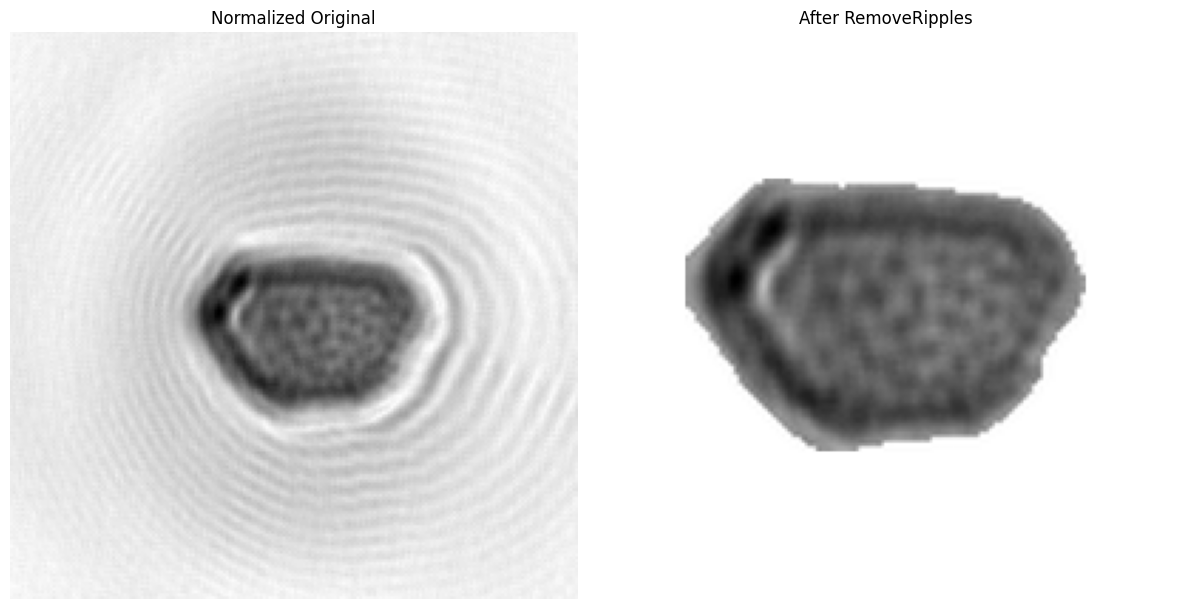

In [3]:
ripple_filter = RemoveRipples(
    method='otsu',
    blur_ksize=5,
    adaptive_blocksize=51,
    adaptive_C=2,
    morph_ksize=5,
    max_scale= 1.7
)

image_path = '../data/subset_poleno/g_carpinus_s_betulus/poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png'

img = Image.open(image_path)
arr = np.array(img).astype(np.float32)
min_val, max_val = arr.min(), arr.max()
if max_val > min_val:
    arr = (arr - min_val) / (max_val - min_val) * 255.0
else:
    arr = np.zeros_like(arr)
gray_img = Image.fromarray(arr.astype(np.uint8), mode='L')

filtered_img = ripple_filter(gray_img)

orig_arr = np.array(gray_img)
filtered_arr = np.array(filtered_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_arr, cmap='gray')
axes[0].set_title('Normalized Original')
axes[0].axis('off')

axes[1].imshow(filtered_arr, cmap='gray')
axes[1].set_title('After RemoveRipples')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class HolographicPollenDataset(Dataset):
    def __init__(self, transform=None, extensions=None):
        self.root_dir = os.path.join(os.getenv("DATA_DIR_PATH"), "subset_poleno")
        self.transform = transform
        self.extensions = extensions or [".png"]

        self.classes = sorted([
            d for d in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, d))
        ])

        raw_samples = []
        for taxa in self.classes:
            cls_dir = os.path.join(self.root_dir, taxa)
            for fname in os.listdir(cls_dir):
                if any(fname.lower().endswith(ext) for ext in self.extensions):
                    path = os.path.join(cls_dir, fname)
                    raw_samples.append((path, taxa))

        groups = {}
        for path, taxa in raw_samples:
            fname = os.path.basename(path)
            if 'image_pairs' not in fname:
                continue
            base = fname.split('image_pairs')[0]
            groups.setdefault((base, taxa), []).append(path)

        # Build pairs list
        self.pairs = []  # (path0, path1, taxa_name)
        for (base, taxa), paths in groups.items():
            p0 = next((p for p in paths if '.0.' in os.path.basename(p)), None)
            p1 = next((p for p in paths if '.1.' in os.path.basename(p)), None)
            
            if p0 and p1:
                self.pairs.append((p0, p1, taxa))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path0, path1, taxa = self.pairs[idx]

        def load_and_normalize(p):
            img = Image.open(p)
            arr = np.array(img).astype(np.float32)
            mn, mx = arr.min(), arr.max()
            if mx > mn:
                arr = (arr - mn) / (mx - mn) * 255.0
            else:
                arr = np.zeros_like(arr)
            return Image.fromarray(arr.astype(np.uint8), mode='L')

        img0 = load_and_normalize(path0)
        img1 = load_and_normalize(path1)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (img0, img1), taxa


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RemoveRipples(
        method='otsu',
        blur_ksize=5,
        adaptive_blocksize=51,
        adaptive_C=2,
        morph_ksize=5
    ),
    transforms.ToTensor(),
])

dataset = HolographicPollenDataset(transform=transform)

In [5]:
torch.all(dataset[0][0][0] == dataset[0][0][1])  # Check if the two images in the pair are equal

tensor(False)

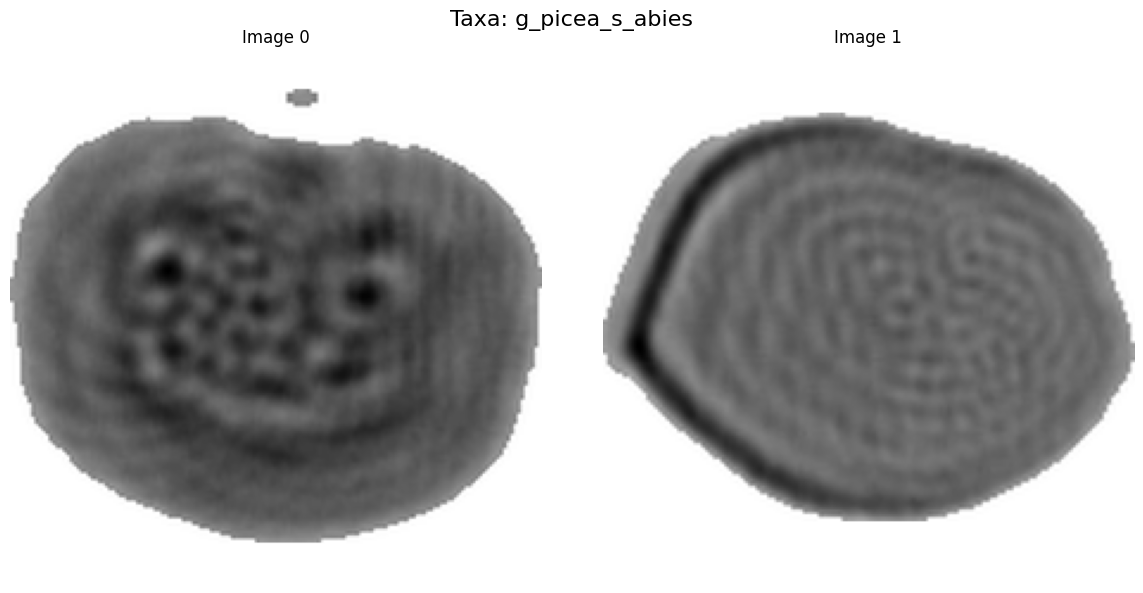

: 

In [ ]:
x = 2000

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(dataset[x][0][0].numpy().transpose(1, 2, 0), cmap='gray')
axes[0].set_title('Image 0')
axes[0].axis('off')
axes[1].imshow(dataset[x][0][1].numpy().transpose(1, 2, 0), cmap='gray')
axes[1].set_title('Image 1')
axes[1].axis('off')
fig.suptitle(f'Taxa: {dataset[x][1]}', fontsize=16)
plt.tight_layout()
plt.show()